<a href="https://colab.research.google.com/github/HeorhiiY/cv-course/blob/main/project/Project0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

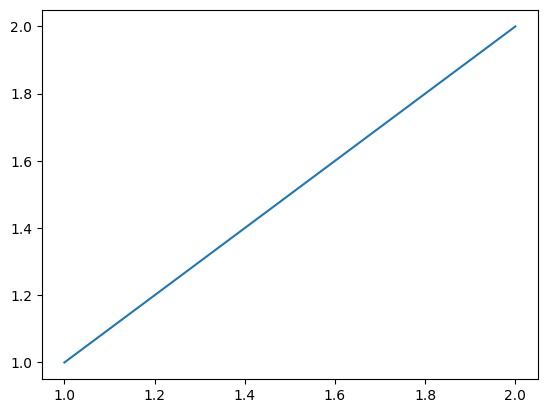

In [9]:
from ultralytics import YOLO
import torch
from tqdm import tqdm
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
plt.plot([1,2], [1,2])

In [8]:


# Define the class mappings: original class ID -> new class ID
parent_labels_dict = {
    -1: "None",
    0: "Fixed-wing Aircraft",
    1: "Passenger Vehicle",
    2: "Truck",
    3: "Railway Vehicle",
    4: "Maritime Vessel",
    5: "Engineering Vehicle",
    6: "Building"
}

def convert_class(child_class):
  if 52 < child_class < 59 or child_class == 3:
    return -1
  elif child_class < 3:
    return -1
  elif child_class < 6:
    return 0 # Passenger Vehicle
  elif child_class < 17:
    return 1 # Truck
  else:
    return -1

# Source and target directories
source_train_labels = "data/tif_images/labels_general_train"
source_val_labels = "data/tif_images/labels_general_val"
target_train_labels = "data/tif_images/train/labels"
target_val_labels = "data/tif_images/val/labels"

# Ensure target directories exist
os.makedirs(target_train_labels, exist_ok=True)
os.makedirs(target_val_labels, exist_ok=True)

def process_labels(source_folder, target_folder):
    """
    Process labels by applying class mapping and copying to the target folder.
    """
    for label_file in tqdm(os.listdir(source_folder)):
        if label_file.endswith(".txt"):
            source_label_path = os.path.join(source_folder, label_file)
            target_label_path = os.path.join(target_folder, label_file)

            # Read the label file
            with open(source_label_path, "r") as f:
                lines = f.readlines()

            # Process the label lines with the class mapping
            new_lines = []
            for line in lines:
                parts = line.strip().split()
                class_id = int(float(parts[0]))  # Original class ID
                new_class_id = convert_class(class_id)
                if new_class_id == -1:
                    continue
                parts[0] = str(new_class_id)
                new_lines.append(" ".join(parts))   
                
            
            # If any labels are valid, save them to the target folder
            if new_lines:
                with open(target_label_path, "w") as f:
                    f.write("\n".join(new_lines) + "\n")
            else:
                # If no valid labels, create an empty label file
                with open(target_label_path, "w") as f:
                    pass  # Empty file

# Process train and val labels
process_labels(source_train_labels, target_train_labels)
process_labels(source_val_labels, target_val_labels)

print("Labels processed and saved successfully!")

100%|████████████████████████████████████████████████████████████████████████████| 6830/6830 [00:02<00:00, 2386.60it/s]

Labels processed and saved successfully!


In [10]:

folder_crops = {'train': 'data/tif_images/train/images/',
                'val': 'data/tif_images/val/images/'}

folder_labels = {'train': 'data/tif_images/train/labels/',
                 'val': 'data/tif_images/val/labels/'}

for folders in [folder_crops, folder_labels]:
    for _, folder in folders.items():
        if not os.path.isdir(folder):
            os.makedirs(folder)

def imread(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

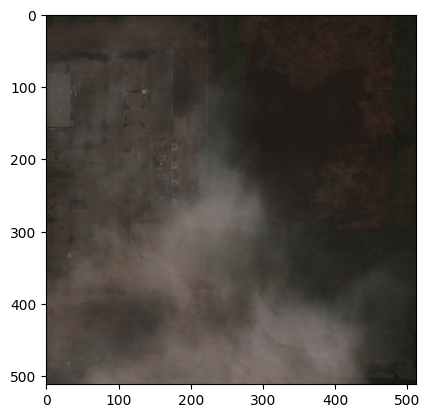

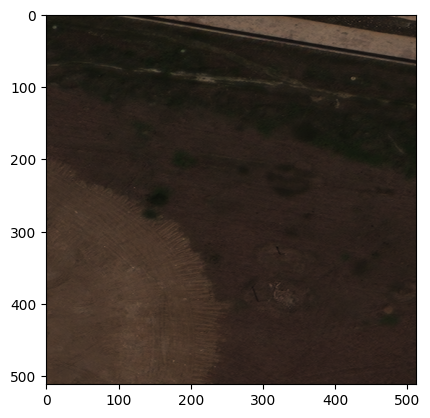

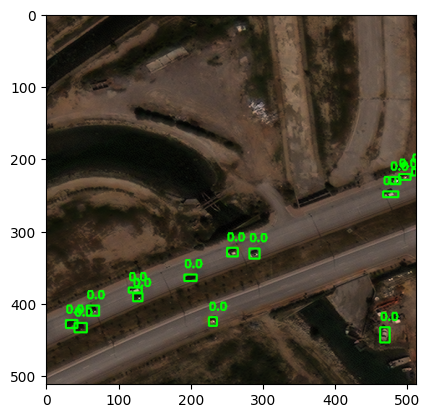

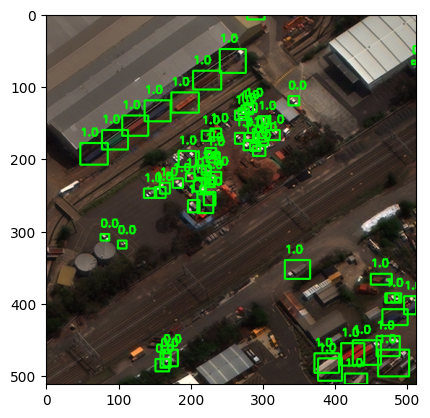

In [18]:
crop_size = 512
for idx, sample in enumerate(np.random.choice(os.listdir(folder_crops['train']), 4)):
    
    # Load image and corresponding labels
    image = imread(os.path.join(folder_crops['train'], sample))
    with open(os.path.join(folder_labels['train'], sample.replace('.tif', '.txt')), 'r') as f:
        labels = f.readlines()

    for box in labels:
        box = np.array([d for d in box.split(' ')], dtype=np.float32)
        class_name = str(box[0])
        # Undo coordinate normalization
        x_center = box[1] * crop_size
        y_center = box[2] * crop_size

        width = box[3] * crop_size
        height = box[4] * crop_size
        
        # Convert from YOLOv8 format to OpenCV rectangle format
        x_start, y_start = int(x_center - width/2), int(y_center - height/2)
        x_end, y_end = int(x_center + width/2), int(y_center + height/2)

        cv2.rectangle(image, (x_start, y_start), (x_end, y_end), color=(0, 255, 0), thickness=2)
        cv2.putText(image, class_name, (x_start, y_start - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # plt.subplot(1,4,idx+1), 
    plt.figure()
    plt.imshow(image)

In [19]:

if torch.cuda.is_available():
    print("CUDA is available. PyTorch will use the GPU.")
else:
    print("CUDA is not available. PyTorch will use the CPU.")

CUDA is available. PyTorch will use the GPU.
